In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

In [3]:
data = '../clean_data/cleaned_DDoS_and_begnin_traffic_dataset.csv'
df = pd.read_csv(data)

# Encode binary target
df['target'] = (df[' Label'] != 'BENIGN').astype(int)

# Use ALL numeric columns except target
X = df.select_dtypes(include=[np.number]).drop(columns=['target'], errors='ignore')
y = df['target'].values

print(f"Total features used: {X.shape[1]}")
print("Target distribution:\n", pd.Series(y).value_counts(normalize=True))

Total features used: 78
Target distribution:
 0    0.679424
1    0.320576
Name: proportion, dtype: float64


### Test train split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Feature Scaling

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to Tensor-friendly format
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)

In [13]:
def plot_roc_curve(y_true, y_prob, model_name):
    """Plot ROC and compute AUC."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_score

### Multi-Layer Perceptron

In [6]:
mlp_model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\n[+] Training MLP...")
mlp_history = mlp_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

2025-11-08 22:22:59.273559: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



[+] Training MLP...
Epoch 1/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9798 - loss: 0.0586 - val_accuracy: 0.9883 - val_loss: 0.0240
Epoch 2/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9920 - loss: 0.0242 - val_accuracy: 0.9958 - val_loss: 0.0167
Epoch 3/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9935 - loss: 0.0199 - val_accuracy: 0.9963 - val_loss: 0.0141
Epoch 4/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.9944 - loss: 0.0173 - val_accuracy: 0.9929 - val_loss: 0.0173
Epoch 5/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9950 - loss: 0.0156 - val_accuracy: 0.9968 - val_loss: 0.0124
Epoch 6/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9949 - loss: 0.0175 - val_accuracy: 0.9969 - val_loss: 0.0115
Epoch 7/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9950 - loss: 0.0149 - val_accuracy: 0.9968 - val_loss: 0.0109
Epoch 8/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accur

2534/2534 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step

MLP Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55088
           1       1.00      0.99      1.00     25993

    accuracy                           1.00     81081
   macro avg       1.00      1.00      1.00     81081
weighted avg       1.00      1.00      1.00     81081

Confusion Matrix:
 [[55010    78]
 [  165 25828]]


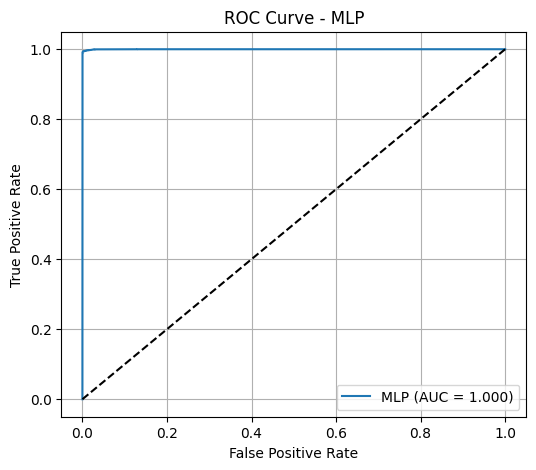

In [14]:
# Evaluate
mlp_probs = mlp_model.predict(X_test_scaled)
mlp_pred = (mlp_probs > 0.5).astype(int)

print("\nMLP Results:")
print(classification_report(y_test, mlp_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, mlp_pred))

mlp_auc = plot_roc_curve(y_test, mlp_probs, "MLP")

### Convolutional Neural Network (CNN)

In [8]:
# Reshape input for CNN: (samples, features, 1)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

cnn_model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\n[+] Training CNN...")
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

/home/passwd/DDoS_Detection/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



[+] Training CNN...
Epoch 1/25
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.9492 - loss: 0.1377 - val_accuracy: 0.9889 - val_loss: 0.0525
Epoch 2/25
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9857 - loss: 0.0513 - val_accuracy: 0.9905 - val_loss: 0.0392
Epoch 3/25
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.9883 - loss: 0.0419 - val_accuracy: 0.9895 - val_loss: 0.0376
Epoch 4/25
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9895 - loss: 0.0380 - val_accuracy: 0.9902 - val_loss: 0.0325
Epoch 5/25
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.9902 - loss: 0.0342 - val_accuracy: 0.9865 - val_loss: 0.0421


2534/2534 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

CNN Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     55088
           1       1.00      0.97      0.98     25993

    accuracy                           0.99     81081
   macro avg       0.99      0.98      0.99     81081
weighted avg       0.99      0.99      0.99     81081

Confusion Matrix:
 [[55015    73]
 [  876 25117]]


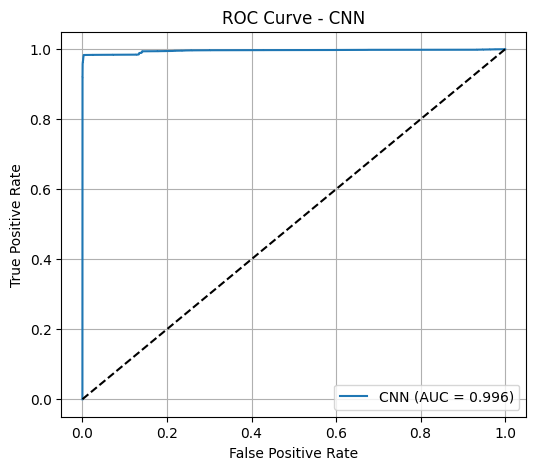

In [15]:
cnn_probs = cnn_model.predict(X_test_cnn)
cnn_pred = (cnn_probs > 0.5).astype(int)

print("\nCNN Results:")
print(classification_report(y_test, cnn_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, cnn_pred))

cnn_auc = plot_roc_curve(y_test, cnn_probs, "CNN")

### LSTM (Recurrent Model)

In [10]:
# Reshape input for LSTM: (samples, timesteps, features)
# We treat each sample as a single sequence of features
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

lstm_model = models.Sequential([
    layers.LSTM(64, input_shape=(1, X_train_scaled.shape[1])),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\n[+] Training LSTM...")
lstm_history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

/home/passwd/DDoS_Detection/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



[+] Training LSTM...
Epoch 1/20
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9839 - loss: 0.0508 - val_accuracy: 0.9951 - val_loss: 0.0199
Epoch 2/20
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9930 - loss: 0.0209 - val_accuracy: 0.9923 - val_loss: 0.0190
Epoch 3/20
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9943 - loss: 0.0179 - val_accuracy: 0.9969 - val_loss: 0.0143
Epoch 4/20
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9947 - loss: 0.0161 - val_accuracy: 0.9939 - val_loss: 0.0150
Epoch 5/20
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9953 - loss: 0.0149 - val_accuracy: 0.9970 - val_loss: 0.0126


2534/2534 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step

LSTM Results:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     55088
           1       1.00      0.99      0.99     25993

    accuracy                           1.00     81081
   macro avg       1.00      0.99      0.99     81081
weighted avg       1.00      1.00      1.00     81081

Confusion Matrix:
 [[55002    86]
 [  312 25681]]


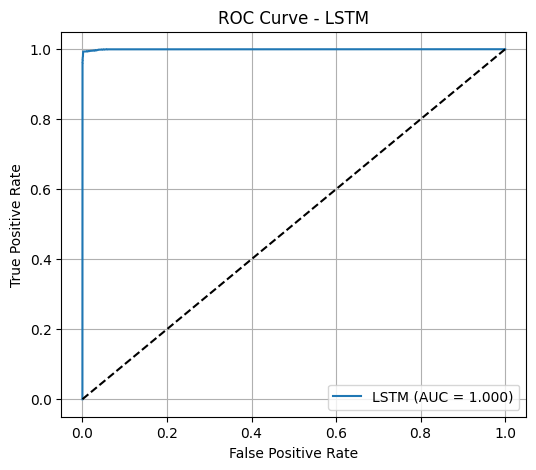

In [16]:
lstm_probs = lstm_model.predict(X_test_lstm)
lstm_pred = (lstm_probs > 0.5).astype(int)

print("\nLSTM Results:")
print(classification_report(y_test, lstm_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, lstm_pred))

lstm_auc = plot_roc_curve(y_test, lstm_probs, "LSTM")

### AUC Summary

In [17]:
print("\n=== AUC SUMMARY ===")
print(f"MLP  : {mlp_auc:.3f}")
print(f"CNN  : {cnn_auc:.3f}")
print(f"LSTM : {lstm_auc:.3f}")


=== AUC SUMMARY ===
MLP  : 1.000
CNN  : 0.996
LSTM : 1.000
